# Result changes with newer environments

Some results calculated using `xarray_parcel` can change when the environment changes. Here we show the differences in some results between the version used in the demo notebook and the newest available environment.

## Setup

In [1]:
%cd ~/git/xarray_parcel

/home/561/tr2908/git/xarray_parcel


In [2]:
import os
import metpy
import xarray
import warnings
import numpy as np
from glob import glob
from metpy.plots import SkewT
from metpy.units import units
import matplotlib.pyplot as plt
import modules.parcel_test as parcel_test
import modules.parcel_functions as parcel
from dask.distributed import Client, LocalCluster

In [3]:
parcel.load_moist_adiabat_lookups()
client = Client()  
print(client)

<Client: 'tcp://127.0.0.1:41557' processes=7 threads=28, memory=125.18 GiB>


In [4]:
plt.rcParams['figure.figsize'] = (16,5)                   # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 12                            # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False          # Don't use offsets in plots.      
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore FutureWarnings (in Dask). 

Print the current versions:

In [5]:
print(f'Metpy version {metpy.__version__}')
print(f'xarray version {xarray.__version__}')
curr_ver = f'metpy_{metpy.__version__}.xarray_{xarray.__version__}'

Metpy version 1.6.2
xarray version 2024.3.0


## Load results

Calculate or load current environment results. Run this section for both the historic version (ie the demo version) and the latest environment; then use the latest environment to compare the two output files.

In [6]:
dat = xarray.open_dataset('test_data.nc').load().chunk({'latitude': 50, 'longitude': 50, 'model_level_number': -1})

In [7]:
%%time
curr_file = f'historic_results/xr_output_{curr_ver}.nc'
if not os.path.exists(curr_file):
    xr = parcel_test.conv_properties_xarray(dat=dat, virt_temp=True, lcl_interp='log', pos_cape_neg_cin=True)
    xr.to_netcdf(curr_file)
    del xr
curr = xarray.open_dataset(curr_file)

CPU times: user 45.2 ms, sys: 12 ms, total: 57.2 ms
Wall time: 54.9 ms


Load historic results to compare to the current environment results.

In [8]:
hist_ver = 'metpy_1.4.1.xarray_2023.4.2' # Version to compare current version to.
f = f'xr_output_{hist_ver}.nc'
hist = xarray.open_dataset(f'historic_results/{f}')

Make scatterplots showing differences between every variable in the historic and current versions.

Differences in dewpoint, max 3.808, max rel 2.24%
Differences in mixing_ratio, max 0.0, max rel 1.09%
Differences in vapour_pressure, max 0.26, max rel 1.06%
Differences in mp_dewpoint, max 0.173, max rel 0.06%
Differences in mixed_cape, max 133.385, max rel 12.77%
Differences in mixed_cin, max 41.466, max rel 449.16%
Differences in max_cape, max 241.432, max rel 10.37%
Differences in max_cin, max 33.962, max rel inf%
Differences in surf_pres, max 2.953, max rel 0.32%
Differences in surface_profile, max 0.531, max rel 0.25%
Differences in virtual_temperature, max 0.533, max rel 0.25%
Differences in surface_lcl_pressure, max 2.953, max rel 0.32%
Differences in surface_lcl_temp, max 0.271, max rel 0.09%
Differences in lcl_virtual_temperature, max 0.318, max rel 0.11%
Differences in surf_temp, max 0.249, max rel 0.08%
Differences in environment_virtual_temperature, max 0.245, max rel 0.08%
Differences in environment_dewpoint, max 3.808, max rel 2.24%
Differences in lfc_pressure, max 135.2

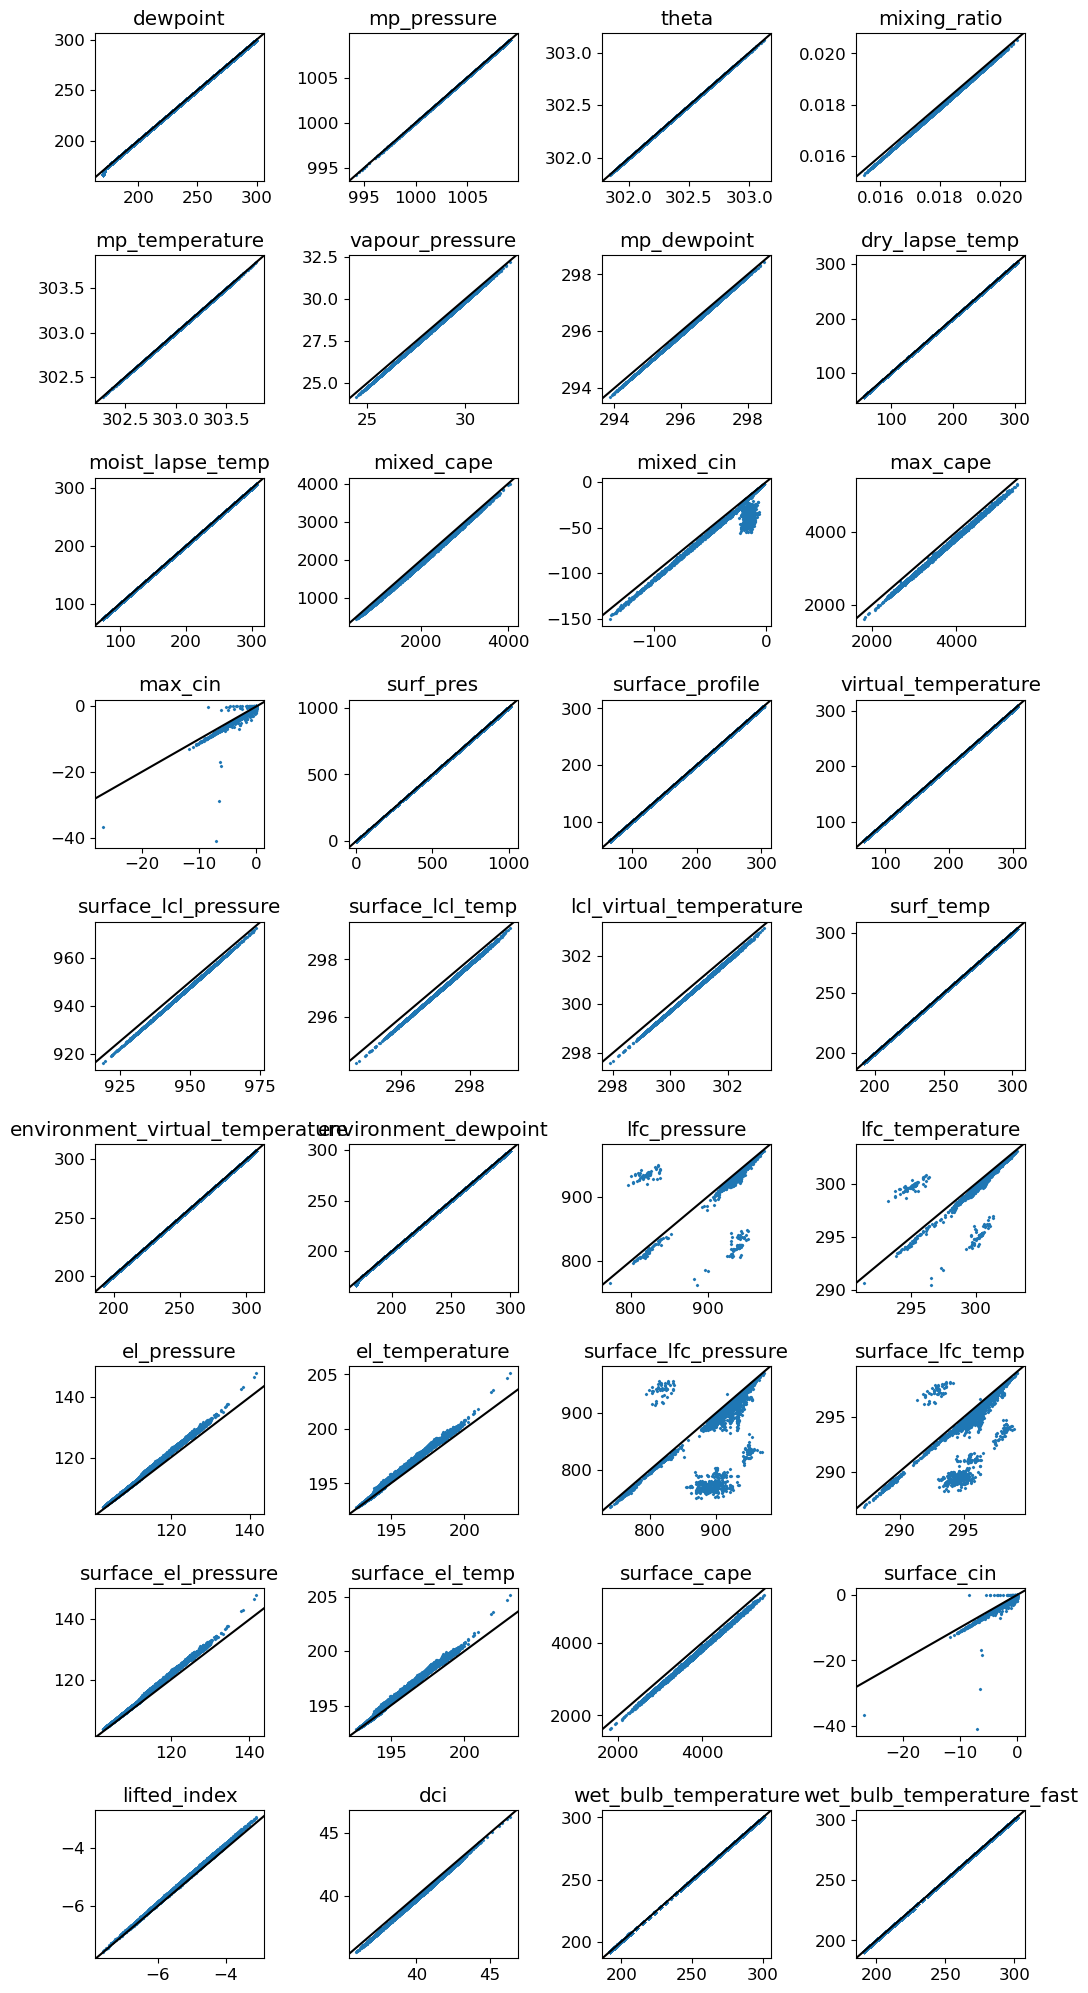

In [9]:
fig, axs = plt.subplots(ncols=4, nrows=9, figsize=(12,25), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, v in enumerate(curr.keys()):

    if not hist[v].equals(curr[v]):
        max_diff = np.abs(hist[v] - curr[v]).max().values
        rel_diff = np.abs((hist[v] - curr[v]) / curr[v] * 100).max().values
        if rel_diff > 0.001:
            print(f'Differences in {v}, max {np.round(max_diff, 3)}, max rel {np.round(rel_diff, 2)}%')
    
    axs.flat[i].scatter(curr[v], hist[v], marker='x', s=2)
    axs.flat[i].set_title(v)
    xlims = axs.flat[i].get_xlim()
    ylims = axs.flat[i].get_ylim()
    axs.flat[i].axline((0,0), (1,1), color='black')
    axs.flat[i].set_xlim(xlims)
    axs.flat[i].set_ylim(ylims)

The differences are mostly in CIN, LFC pressure and temperature. Tracing the results back by calculating mixed CIN (below), it can be shown that:

* The big differences in CIN come from `parcel_profile_with_lcl()`.
* The main differences are due to differences in `environment_virtual_temperature` as calculated in `parcel_profile_with_lcl()`.
* Differences in environmental virtual temperature come from differences in `mixing_ratio()` between versions.
* These small differences come from MetPy's `mixing_ratio_from_relative_humidity()`.
* The small differences in mixing ratio lead to small changes in environmental virtual temperature, leading to larger differences in LFC calculation and therefore in CIN which is defined from surface to LFC.

Looking at the changes for MetPy I can see that the calculation of mixing ratios has been updated between versions 1.4.1 and 1.6.2 (https://github.com/Unidata/MetPy/compare/v1.4.1...v1.6.2#diff-55d7c597060e361ce1e2468b18cf0abde3582a14fc11e320bc468f7f7a3ca480).

There is a small bias between versions in surface-based CAPE, which comes from differences in dewpoint temperatures between MetPy versions, in `dewpoint_from_specific_humidity()`. In version 1.4.1 specific humidity is translated to relative humidity and the dewpoint is found using relative humidity; in 1.6.2 the dewpoint is calculated directly using specific humidity and pressure.

Large differences in CIN can occur when there is a low temperature inversion and small changes in the parcel virtual temperature curve can either include or exclude a large area of negative buoyancy.

## Detailed code to track down differences

Go through the whole process of calculating mixed parcel CAPE and CIN and save outputs at each step along the way, to detect where changes occur. Run this code under each environment to generate the .nc files, then use the code below to compare.

In [10]:
# ### parcel.mixed_layer_cape_cin():
# pressure, temperature, dewpoint, mp = parcel.mix_layer(pressure=dat.pressure,
#                                                       temperature=dat.temperature,
#                                                       dewpoint=hist.dewpoint,
#                                                       depth=100)
# pressure.to_netcdf(f'historic_results/pressure_{curr_ver}.nc')
# temperature.to_netcdf(f'historic_results/temperature_{curr_ver}.nc')
# dewpoint.to_netcdf(f'historic_results/dewpoint_{curr_ver}.nc')
# mp.to_netcdf(f'historic_results/mp_{curr_ver}.nc')

# ## --> cape_cin():
# profile = parcel.parcel_profile_with_lcl(pressure=pressure,
#                                          temperature=temperature,
#                                          dewpoint=dewpoint,
#                                          parcel_temperature=mp.temperature,
#                                          parcel_pressure=mp.pressure,
#                                          parcel_dewpoint=mp.dewpoint)
# profile.to_netcdf(f'historic_results/profile_{curr_ver}.nc')

# ## --> parcel_profile_with_lcl()
# profile_lcl = parcel.parcel_profile(pressure=pressure, 
#                                     parcel_pressure=mp.pressure,
#                                     parcel_temperature=mp.temperature,
#                                     parcel_dewpoint=mp.dewpoint)
# profile_lcl.to_netcdf(f'historic_results/profile_lcl_{curr_ver}.nc')

# # mix_ratio = parcel.mixing_ratio(temperature=temperature, 
# #                                 dewpoint=dewpoint,
# #                                 pressure=pressure)
# # mix_ratio.name = 'mix_ratio'
# # mix_ratio.to_netcdf(f'historic_results/mix_ratio_{curr_ver}.nc')

# relative_humidity = metpy.calc.relative_humidity_from_dewpoint(
#         temperature=temperature,
#         dewpoint=dewpoint)
# relative_humidity.name = 'relative_humidity'
# relative_humidity.metpy.dequantify().to_netcdf(f'historic_results/relative_humidity_{curr_ver}.nc')

# res = metpy.calc.mixing_ratio_from_relative_humidity( 
#     pressure=pressure,
#     temperature=temperature,
#     relative_humidity=relative_humidity)
# if isinstance(res, xarray.DataArray):
#     res = res.metpy.dequantify()
#     res.attrs['units'] = 'kg kg$^{-1}$'
# res.name = 'mix_ratio'
# res.to_netcdf(f'historic_results/mix_ratio_{curr_ver}.nc')
# mix_ratio = res

# virtual_temp = parcel.virtual_temperature(temperature=temperature,
#                                           mixing_ratio=mix_ratio)
# virtual_temp.to_netcdf(f'historic_results/virtual_temp_{curr_ver}.nc')

# parcel_lfc_el = parcel.lfc_el(pressure=profile.pressure,
#                               parcel_temperature=profile.virtual_temperature, 
#                               temperature=profile.environment_virtual_temperature, 
#                               lcl_pressure=profile.lcl_pressure, 
#                               lcl_temperature=profile.lcl_virtual_temperature)
# parcel_lfc_el.to_netcdf(f'historic_results/parcel_lfc_el_{curr_ver}.nc')

# # Calculate CAPE and CIN.
# cape_cin = parcel.cape_cin_base(pressure=profile.pressure,
#                                 temperature=profile.environment_virtual_temperature, 
#                                 lfc_pressure=parcel_lfc_el.lfc_pressure, 
#                                 el_pressure=parcel_lfc_el.el_pressure, 
#                                 parcel_temperature=profile.virtual_temperature).load()
# cape_cin.to_netcdf(f'historic_results/cape_cin_{curr_ver}.nc')

The following code block can be changed so that either the current or historical version of `profile` is used; in the current environment, using the historical profile largely reduces differences in CIN or CAPE.

In [11]:
# pressure = xarray.open_dataset(f'historic_results/pressure_{hist_ver}.nc').pressure
# temperature = xarray.open_dataset(f'historic_results/temperature_{hist_ver}.nc').temperature
# dewpoint = xarray.open_dataset(f'historic_results/dewpoint_{hist_ver}.nc').dewpoint
# mp = xarray.open_dataset(f'historic_results/mp_{hist_ver}.nc')

# ## --> cape_cin():
# profile_new = parcel.parcel_profile_with_lcl(pressure=pressure,
#                                          temperature=temperature,
#                                          dewpoint=dewpoint,
#                                          parcel_temperature=mp.temperature,
#                                          parcel_pressure=mp.pressure,
#                                          parcel_dewpoint=mp.dewpoint)
# profile_old = xarray.open_dataset(f'historic_results/profile_{hist_ver}.nc')

# parcel_lfc_el = parcel.lfc_el(pressure=profile.pressure,
#                               parcel_temperature=profile.virtual_temperature, 
#                               temperature=profile_old.environment_virtual_temperature, 
#                               lcl_pressure=profile.lcl_pressure, 
#                               lcl_temperature=profile.lcl_virtual_temperature)
# # #parcel_lfc_el = xarray.open_dataset(f'historic_results/parcel_lfc_el_{hist_ver}.nc')

# # # Calculate CAPE and CIN.
# cape_cin = parcel.cape_cin_base(pressure=profile.pressure,
#                                 temperature=profile.environment_virtual_temperature, 
#                                 lfc_pressure=parcel_lfc_el.lfc_pressure, 
#                                 el_pressure=parcel_lfc_el.el_pressure, 
#                                 parcel_temperature=profile.virtual_temperature).load()

A bias in surface based CAPE between two environments is traced to differences in MetPy's dewpoint calculation.

In [12]:
# # Profile for surface-based parcel ascent.
# pressure=dat.pressure
# temperature=dat.temperature
# dewpoint=curr.dewpoint
# vert_dim = 'model_level_number'
# parcel_temperature=dat.temperature.isel({vert_dim: 0})
# parcel_pressure=dat.pressure.isel({vert_dim: 0})
# parcel_dewpoint=curr.dewpoint.isel({vert_dim: 0})

# profile = parcel.parcel_profile_with_lcl(pressure=pressure,
#                                          temperature=temperature,
#                                          dewpoint=dewpoint,
#                                          parcel_temperature=parcel_temperature,
#                                          parcel_pressure=parcel_pressure,
#                                          parcel_dewpoint=parcel_dewpoint)
# #profile.to_netcdf(f'historic_results/profile_{curr_ver}.nc')

# profile_hist = xarray.open_dataset(f'historic_results/profile_{hist_ver}.nc')

# parcel_lfc_el = parcel.lfc_el(pressure=profile.pressure,
#                               parcel_temperature=profile.virtual_temperature, 
#                               temperature=profile.environment_virtual_temperature, 
#                               lcl_pressure=profile.lcl_pressure, 
#                               lcl_temperature=profile.lcl_virtual_temperature)

# cape_cin = parcel.cape_cin_base(pressure=profile.pressure,
#                                 temperature=profile.environment_virtual_temperature, 
#                                 lfc_pressure=parcel_lfc_el.lfc_pressure, 
#                                 el_pressure=parcel_lfc_el.el_pressure, 
#                                 parcel_temperature=profile.virtual_temperature).load()

The following code block is a basic loop to detect differences between variables.

In [13]:
# assert hist_ver != curr_ver, 'Current version must be different from historic version.'

# var = 'cape_cin'
# #c = xarray.Dataset({'mix_ratio': mix_ratio})
# c = cape_cin
# h = hist[[f'surface_{x}' for x in list(cape_cin.keys())]]
# h = h.rename({f'surface_{x}': x for x in list(cape_cin.keys())})

# for k in h.keys():
#     if not h[k].equals(c[k]):
#         max_diff = np.abs(h[k] - c[k]).max().values
#         rel_diff = np.abs((h[k] - c[k]) / h[k] * 100).max().values
#         if rel_diff > 0.001:
#             print(f'{var}: differences in {k}, max {np.round(max_diff, 3)}, max rel {np.round(rel_diff, 2)}%')
#             plt.scatter(h[k], c[k])
#             plt.axline((0,0), (1,1), color='red')
#             plt.show()

# del h, c

In the following code a single point for which there are larger differences in CIN is plotted, showing the temperature inversion which causes the LFC to change between environment versions.

In [14]:
#p = curr.where(np.logical_and(curr.mixed_cin > -13.2, hist.mixed_cin < -54.5), drop=True)
d = dat.sel(longitude=130.94339, latitude=-10.791798).squeeze()
hist_p = hist.sel(longitude=130.94339, latitude=-10.791798).squeeze()
curr_p = curr.sel(longitude=130.94339, latitude=-10.791798).squeeze()
#d['dewpoint'] = curr_p.dewpoint
d['dewpoint'] = hist_p.dewpoint
d = d.load()

In [15]:
def test_point(d, surface):
    pressure, temperature, dewpoint, mp = parcel.mix_layer(pressure=d.pressure,
                                                           temperature=d.temperature,
                                                           dewpoint=d.dewpoint,
                                                           depth=100)
    if surface:
        profile = parcel.parcel_profile_with_lcl(pressure=pressure,
                                                 temperature=temperature,
                                                 dewpoint=dewpoint,
                                                 parcel_temperature=d.temperature.isel(model_level_number=0),
                                                 parcel_pressure=d.pressure.isel(model_level_number=0),
                                                 parcel_dewpoint=d.dewpoint.isel(model_level_number=0))
    else:
        profile = parcel.parcel_profile_with_lcl(pressure=pressure,
                                                 temperature=temperature,
                                                 dewpoint=dewpoint,
                                                 parcel_temperature=mp.temperature,
                                                 parcel_pressure=mp.pressure,
                                                 parcel_dewpoint=mp.dewpoint)
    
    parcel_lfc_el = parcel.lfc_el(pressure=profile.pressure,
                                  parcel_temperature=profile.virtual_temperature, 
                                  temperature=profile.environment_virtual_temperature, 
                                  lcl_pressure=profile.lcl_pressure, 
                                  lcl_temperature=profile.lcl_virtual_temperature)
    print(parcel_lfc_el.load())

    cape_cin = parcel.cape_cin_base(pressure=profile.pressure,
                                    temperature=profile.environment_virtual_temperature, 
                                    lfc_pressure=parcel_lfc_el.lfc_pressure, 
                                    el_pressure=parcel_lfc_el.el_pressure, 
                                    parcel_temperature=profile.virtual_temperature)
    print(f'CAPE: {np.round(cape_cin.cape.values, 2)}')
    print(f'CIN: {np.round(cape_cin.cin.values, 2)}')
    
    # Plot skewT with results.
    p = d.pressure.values * units.hPa
    T = d.temperature.values * units.K
    Td = hist_p.dewpoint.values * units.K
    
    # Create the Skew-T plot
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=45)
    
    # Plot temperature and dew point
    skew.plot(p, T, 'r', label='Temperature')
    skew.plot(p, Td, 'g', label='Dew Point')
    skew.plot(profile.pressure.values * units.hPa, 
              profile.temperature.values * units.K, 
              'b', label='Lifted parcel')
    
    # Add dry adiabats, moist adiabats, and mixing lines
    #skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K, alpha=0.25, color='orangered')
    #skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K, alpha=0.25, color='tab:green')
    skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa, linestyle='dotted', color='tab:blue')
    
    # Set appropriate axes limits
    skew.ax.set_xlim(-10, 40)
    skew.ax.set_ylim(1020, 100)
    
    # Add titles
    plt.title('Skew-T Log-P Plot')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Pressure (hPa)')
    
    # Show the plot
    plt.show()

<xarray.Dataset> Size: 48B
Dimensions:             ()
Coordinates:
    latitude            float32 4B -10.79
    longitude           float32 4B 130.9
    model_level_number  int64 8B 15
Data variables:
    lfc_pressure        float64 8B 920.0
    lfc_temperature     float64 8B 299.0
    el_pressure         float64 8B 122.6
    el_temperature      float64 8B 197.0
CAPE: 2715.81
CIN: -9.56


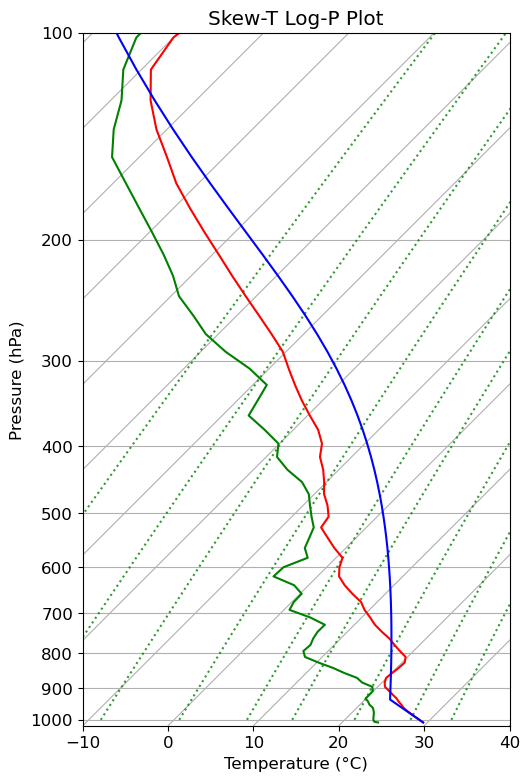

In [16]:
test_point(d, surface=True)

<xarray.Dataset> Size: 48B
Dimensions:             ()
Coordinates:
    latitude            float32 4B -10.79
    longitude           float32 4B 130.9
    model_level_number  int64 8B 15
Data variables:
    lfc_pressure        float64 8B 760.3
    lfc_temperature     float64 8B 290.2
    el_pressure         float64 8B 155.5
    el_temperature      float64 8B 207.6
CAPE: 1395.75
CIN: -54.25


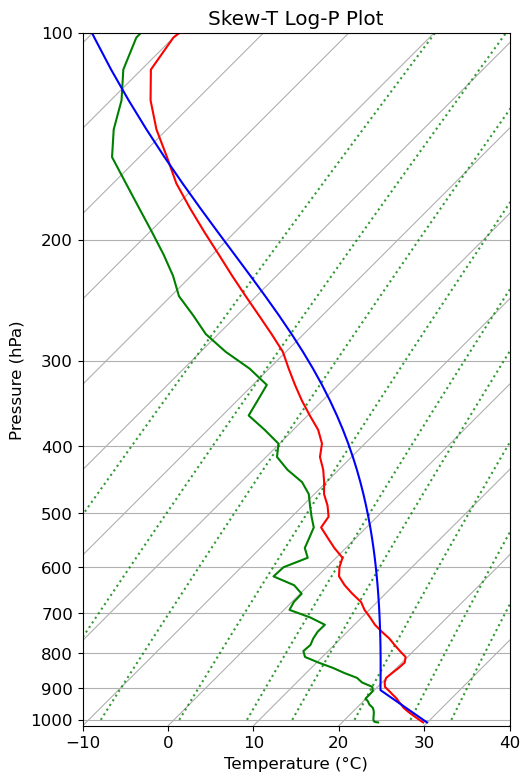

In [17]:
test_point(d, surface=False)